<img style="float: left;" src="figures/Perm.png" width="20%">   

# <font color='Blue'> $\;$ Geothermal doublet in fluvial reservoir</font>

## <font color='Blue'>Introduction</font>
###  In this exercise, we run simulation in a 3D channelized reservoir.

## <font color='blue'>The objectives:</font>
1. Introduce custom <font color='red'>'Model'</font> class based on 
 * Class [DartsModel](https://gitlab.com/open-darts/open-darts/-/blob/development/darts/models/darts_model.py) with base model capabilities
 * Class [StructReservoir](https://gitlab.com/open-darts/open-darts/-/blob/development/darts/reservoirs/struct_reservoir.py) with structured reservoir
 * Class [GeothermalPhysics](https://gitlab.com/open-darts/open-darts/-/blob/development/darts/physics/geothermal/physics.py) for geothermal engine is used
 * Class [PropertyContainer](https://gitlab.com/open-darts/open-darts/-/blob/development/darts/physics/geothermal/property_container.py) for allocating property evaluator needed in the simulation
 * Class [GeothermalProperties](https://gitlab.com/open-darts/open-darts/-/blob/development/darts/physics/properties/iapws/iapws_property.py) for geothermal fluid based on IAPWS-97 Equatipn of State.
2. Use run_python procedure to control run from the python script
3. Introduce wells and change their location

<img style="float: left;" src="slides/Slide15.PNG" width="60%">

<img style="float: left;" src="slides/Slide16.PNG" width="60%">

<img style="float: left;" src="slides/Slide17.PNG" width="60%">

In [4]:
from darts.reservoirs.struct_reservoir import StructReservoir
from darts.physics.geothermal.physics import Geothermal
from darts.physics.geothermal.property_container import PropertyContainer
from darts.models.darts_model import DartsModel
from darts.tools.keyword_file_tools import load_single_keyword
from darts.engines import redirect_darts_output, well_control_iface

import numpy as np

redirect_darts_output('fluvial_model.log')

## <font color='Blue'>Brief Introduction of model inheritance:</font>

* Here create the <font color='red'>'Model' </font>  class, which inherits from <font color='red'>DartsModel</font> (the base class).
* It keeps all the functionalities of <font color='red'>DartsModel</font> and can also be extended to add more functionalities.
* If a function is redefined in subclass, the function in base class with identical name will be overridden.

In [5]:
class Model(DartsModel):
    def __init__(self, n_points=128):
        # call base class constructor
        super().__init__()
        
        self.timer.node["initialization"].start()
        
        # parameters for the reservoir
        (nx, ny, nz) = (60, 60, 3)
        nb   = nx * ny * nz
        perm = np.ones(nb) * 2000
        # perm = load_single_keyword('perm.in', 'PERMX')
        perm = perm[:nb]
        
        poro = np.ones(nb) * 0.2
        self.dx = 30
        self.dy = 30
        dz   = np.ones(nb) * 30
                
        # discretize structured reservoir
        self.reservoir = StructReservoir(self.timer, nx=nx, ny=ny, nz=nz, dx=self.dx, dy=self.dy, dz=dz, permx=perm,
                                         permy=perm, permz=perm*0.1, poro=poro, depth=2000, hcap=2200, rcond=500)
        
        # add open boundaries
        self.reservoir.boundary_volumes['yz_minus'] = 1e8
        self.reservoir.boundary_volumes['yz_plus'] = 1e8
        self.reservoir.boundary_volumes['xz_minus'] = 1e8
        self.reservoir.boundary_volumes['xz_plus'] = 1e8
                                           
        # add well's locations
        self.iw = [30, 30]
        self.jw = [14, 46]

        # create pre-defined physics for geothermal
        property_container = PropertyContainer()
        property_container.output_props = {'T,degrees': lambda: property_container.temperature - 273.15}
        
        self.physics = Geothermal(self.timer, n_points, 1, 351, 1000, 10000, cache=False)
        self.physics.add_property_region(property_container)
        self.physics.init_physics()
        
        # timestep parameters
        self.set_sim_params(mult_ts=2, first_ts=1e-3, max_ts=365, tol_newton=1e-2)

        self.timer.node["initialization"].stop()
    
    def set_wells(self):
        self.reservoir.add_well("INJ")
        for k in range(1, self.reservoir.nz):
            self.reservoir.add_perforation("INJ", res_cell_idx=(self.iw[0], self.jw[0], k + 1),
                                           well_diameter=0.32, ms_epm=True)

        # add well
        self.reservoir.add_well("PRD")
        for k in range(1, self.reservoir.nz):
            self.reservoir.add_perforation("PRD", res_cell_idx=(self.iw[1], self.jw[1], k + 1),
                                           well_diameter=0.32, ms_epm=True)


    def set_initial_conditions(self):
        # initialization with constant pressure and temperature
        input_distribution = {"pressure": 200.,
                              "temperature": 350.
                             }
        self.physics.set_initial_conditions_from_array(mesh=self.reservoir.mesh, input_distribution=input_distribution)

    def set_well_controls(self):
        # activate wells with rate control for injector and producer
        for i, w in enumerate(self.reservoir.wells):
            if 'INJ' in w.name:
                self.physics.set_well_controls(wctrl=w.control,
                                               control_type=well_control_iface.VOLUMETRIC_RATE,
                                               is_inj=True,
                                               target=5000,
                                               phase_name='water', 
                                               inj_temp=300
                                               )
            else:
                self.physics.set_well_controls(wctrl=w.control,
                                               control_type=well_control_iface.VOLUMETRIC_RATE, 
                                               is_inj=False, 
                                               target=5000
                                               )

## <font color='Blue'>Now we can run the model:</font>

In [6]:
m = Model()
m.init()
m.set_output(output_folder='output_2')

# output initial conditions
prop_list = m.physics.vars + m.output.properties
m.output.output_to_vtk(output_properties=prop_list, ith_step=0)
m.run(1e-3)

for t in range(3):
    # run and output every 10 years (30 in total)
    m.run(10*365, restart_dt=365)
    m.output.output_to_vtk(output_properties=prop_list, ith_step=t+1)

# print timers and statistics for the run
m.print_timers()
m.print_stat()

darts-package built on 30/01/2026 16:43:15 by smoslehi@HW1T6M3 from v1.1.3-1733-g0dbd8e12-dirty
Building connection list...
Simulation parameters:
	 eta = [1.e+20 1.e+20]
	 dt_first = 0.001
	 dt_min = 1e-15
	 dt_mult = 2
	 dt_max = 365
	 newton_tol = 0.01
	 newton_tol_wel_mult = 100.0
	 newton_tol_stationary = 0.001
	 newton_max_iter = 20
	 linear_tol = 1e-05
	 linear_max_iter = 50
	 linear_type = None
	 linear_print_level = None
	 line_search = False
	 min_line_search_update = 0.0001
	 coupled_well_res_norm_method = 1
Interpolating missing data in DX...
Interpolating missing data in DY...
#1	T=0.001	DT=0.001	NI=3	LI=3	DT_MULT=  2	dX=[0.747 1.15 ]
----- TS = 1(0), NI = 3(0), LI = 3(0) -----
#1	T=365.001	DT=365	NI=4	LI=4	DT_MULT=  2	dX=[1.569000e+00 3.651773e+03]
#2	T=730.001	DT=365	NI=3	LI=3	DT_MULT=  2	dX=[2.320000e-01 1.210538e+03]
#3	T=1095	DT=365	NI=2	LI=2	DT_MULT=  2	dX=[1.24000e-01 8.36451e+02]
#4	T=1460	DT=365	NI=2	LI=2	DT_MULT=  2	dX=[9.50000e-02 6.65235e+02]
#5	T=1825	DT=365	N

In [10]:
import pandas as pd
# output well information to Excel file
# td = pd.DataFrame.from_dict(m.physics.engine.time_data)
td = pd.DataFrame.from_dict(m.output.store_well_time_data())
# convert K to degrees
for k in td.keys():
    if 'BHT' in k:
        td[k] -= 273.15
        td = td.rename(columns={k: k.replace('(K)', '(degrees)')})
# writer = pd.ExcelWriter('well_time_data.xlsx')
# td.to_excel(writer, 'Sheet1')
# writer.close()

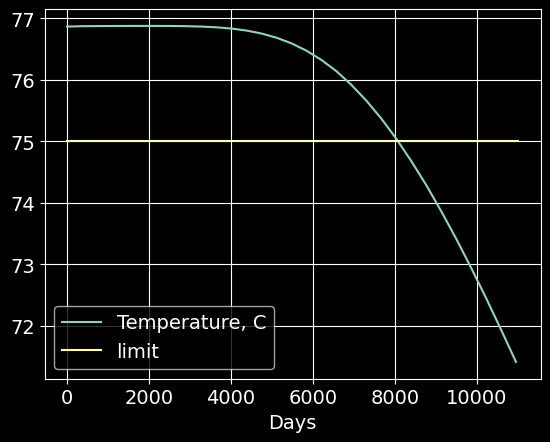

In [11]:
import matplotlib.pyplot as plt
# plot temperature at production well and technological limit
string = f'well_PRD_BHT'
ax1 = td.plot(x='time', y=[col for col in td.columns if string in col])
ax1.plot([0, 1.1e4],[75, 75])
ax1.tick_params(labelsize=14)
ax1.set_xlabel('Days', fontsize=14)
ax1.legend(['Temperature, C', 'limit'], fontsize=14)
plt.grid()
plt.show()

In [12]:
import pyvista as pv
import os

# get vts data
sol = pv.read(os.path.join(m.output_folder,'vtk_files', 'solution_ts3.vts'))

# define plotter
plotter = pv.Plotter()

# set temperature as active scalar
sol.set_active_scalars('T,degrees')

# add threshold levels
thresT = sol.threshold([25, 75], invert=False)

# add outline of mesh
outline = sol.outline()

# add elements to plotter
plotter.set_background('#52576c')
plotter.add_mesh(outline, color='k')
try: # in case there is an issue in PyVista "'NoneType' object is not callable"
    plotter.add_mesh(thresT, cmap='coolwarm',
                     scalar_bar_args={'title':'Temperature (\N{DEGREE SIGN}C)'})
except:
    plotter.add_mesh(thresT,
                     scalar_bar_args={'title':'Temperature (\N{DEGREE SIGN}C)'})
mesh = pv.read(os.path.join(m.output_folder, 'vtk_files', 'mesh.vts'))
mesh.set_active_scalars('permx')
# threshold for plotting permeability map
thresperm = mesh.threshold([1, 7000], scalars='permx',
                           continuous=True)
# plot permebility map with opacity
plotter.add_mesh(thresperm, scalars='permx', cmap='viridis',
                 opacity=0.25,
                 scalar_bar_args={'title':'Permeability (mD)'})

# add wells as lines
ix_coord = (m.iw[0] - 0.5) * m.dx
iy_coord = (m.jw[0] - 0.5) * m.dy
px_coord = (m.iw[1] - 0.5) * m.dx
py_coord = (m.jw[1] - 0.5) * m.dy

injline = np.array([[ix_coord, iy_coord, -1700], [ix_coord, iy_coord, -2100]])
prodline = np.array([[px_coord, py_coord, -1700], [px_coord, py_coord, -2100]])

_ = plotter.add_lines(injline, color='b', name='injector')
_ = plotter.add_lines(prodline, color='r', name='producer')
_ = plotter.add_axes(line_width=5, labels_off=False)

plotter.camera_position = [3,5,2] 
plotter.camera.zoom(1.3)

plotter.show()

ModuleNotFoundError: No module named 'pyvista'

## <font color='Blue'>Tasks in this workshop:</font>

Plot and copy production temperature figure after each task items.

1. Load 'PERMX' keyword from file 'perm.in'
2. Rerun the simulation, compare lifetime with homegeneous case
3. Change location of the wells across the channels
4. Rerun and compare the lifetime, explain why it is different

More details on geothermal in fluvial reservoirs can be found in https://doi.org/10.1016/j.renene.2021.07.017.